In [173]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go
#initiate visualization library for jupyter notebook 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)
%matplotlib inline

In [174]:
#defining visualizaition functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

In [175]:
# loading data 
customers_ = pd.read_csv("C:/Users/admin.ydjen/Documents/Hetic/archive/olist_customers_dataset.csv")
order_items_ = pd.read_csv("C:/Users/admin.ydjen/Documents/Hetic/archive/olist_order_items_dataset.csv")
order_payments_ = pd.read_csv("C:/Users/admin.ydjen/Documents/Hetic/archive/olist_order_payments_dataset.csv")
orders_ = pd.read_csv("C:/Users/admin.ydjen/Documents/Hetic/archive/olist_orders_dataset.csv")

In [176]:
# displaying data shape
#dataset = [customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers, category_name_translation]
dataset = {
    'Customers': customers_,
    'Order Items': order_items_,
    'Payments': order_payments_,
    'Orders': orders_
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]


In [177]:
# displaying dataset column names
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



In [178]:
# checking for null values in datasets
for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Customers: False
Order Items: False
Payments: False
Orders: True


In [179]:
# taking count for dataset with missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



In [180]:
# creating master dataframe 
order_payments_.head()
df1 = order_payments_.merge(order_items_, on='order_id')
df2 = df1.merge(orders_, on='order_id')
df = df2.merge(customers_, on='customer_id')
print(df.shape)

(117601, 22)


In [181]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [182]:
# cleaning up name columns
df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()
# engineering new/essential columns
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Changing the month attribute for correct ordenation
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)
#creating year month column
df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [183]:
# displaying summary staticstics of columns
df.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,115034,117601,117601,117601.000000,117601,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,NaN,NaN,NaN,98665,7,NaN,NaN,NaN,NaN,NaN,95419,NaN,4110,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,NaN,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,NaN,NaN,NaN,NaN,NaN,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,NaN,NaN,NaN,63,115035,NaN,NaN,NaN,NaN,NaN,75,NaN,18590,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,2018-01-06 07:44:03.344223232,120.824783,20.045990,NaN,NaN,2017-12-30 16:19:35.878368256,2017-12-31 03:47:56.832505344,2018-01-03 18:13:17.468819968,2018-01-13 06:45:43.565711104,2018-01-23 12:55:57.155126016,NaN,35051.793097,NaN,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,2016-09-19 00:15:34,0.850000,0.000000,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,2017-09-18 22:15:28,39.900000,13.080000,NaN,NaN,2017-09-11 21:42:39,2017-09-12 11:11:34,2017-09-14 23:09:42,2017-09-25 14:09:30.249999872,2017-10-03 00:00:00,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000
50%,NaN,1.000000,NaN,2.000000,108.210000,1.000000,NaN,NaN,2018-01-25 11:57:49,74.900000,16.290000,NaN,NaN,2018-01-18 13:37:27,2018-01-18 20:14:08,2018-01-23 20:43:30,2018-02-01 19:17:46,2018-02-14 00:00:00,NaN,24315.000000,NaN,NaN,12.000000,2018.000000,6.000000,3.000000,15.000000,NaN,NaN,NaN,201801.000000
75%,NaN,1.000000,NaN,4.000000,189.260000,1.000000,NaN,NaN,2018-05-10 07:51:17,134.900000,21.190000,NaN,NaN,2018-05-03 22:43:17,2018-05-04 11:35:16.750000128,2018-05-07 16:34:00,2018-05-15 16:52:09.249999872,2018-05-25 00:00:00,NaN,58600.000000,NaN,NaN,16.000000,2018.000000,8.000000,4.000000,19.000000,NaN,NaN,NaN,201805.000000
max,NaN,29.000000,NaN,24.000000,13664.080000,21.000000,NaN,NaN,2020-04-09 22:35:08,6735.000000,409.680000,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,99990.000000,NaN,NaN,146.000000,2018.000000,12.000000,6.000000,23.000000,NaN,NaN,NaN,201809.000000


In [184]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,order_delivered_customer_date,delivery_against_estimated,order_delivered_carrier_date,order_approved_at,month_year,order_purchase_mon,order_purchase_day,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,order_purchase_year,customer_state,customer_city,customer_zip_code_prefix,customer_unique_id,order_estimated_delivery_date,order_id,payment_sequential,order_purchase_timestamp,order_status,customer_id,freight_value,price,shipping_limit_date,seller_id,product_id,order_item_id,payment_value,payment_installments,payment_type,month_y
Values,2567.000000,2567.000000,1245.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.182805,2.182805,1.058664,0.012755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [186]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  custo

In [187]:
# excluding incomplete 2012 data and displaying first 3 rows of master dataframe
df = df.query("month_year != '2016-12' and month_year != '2016-10'")
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712


In [188]:
#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df_revenue = df.groupby(['month_year'])['payment_value'].sum().reset_index()
df_revenue

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


In [189]:
#calculating for monthly revenie growth rate
# using pct_change() function to see monthly percentage change
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,month_year,payment_value,MonthlyGrowth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


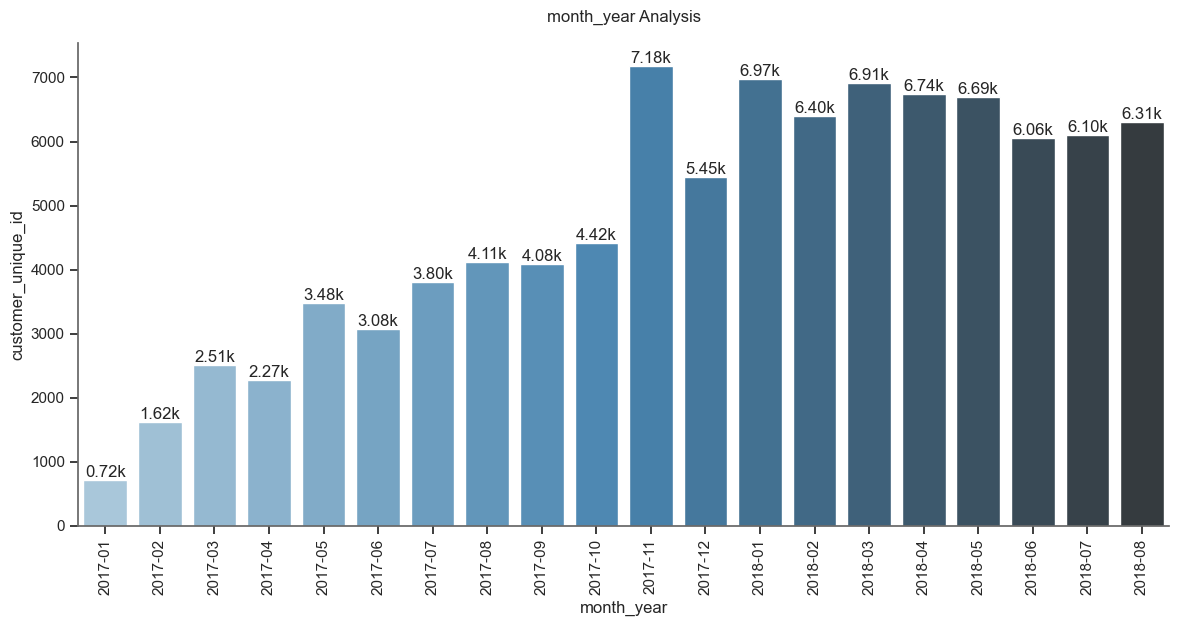

In [190]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

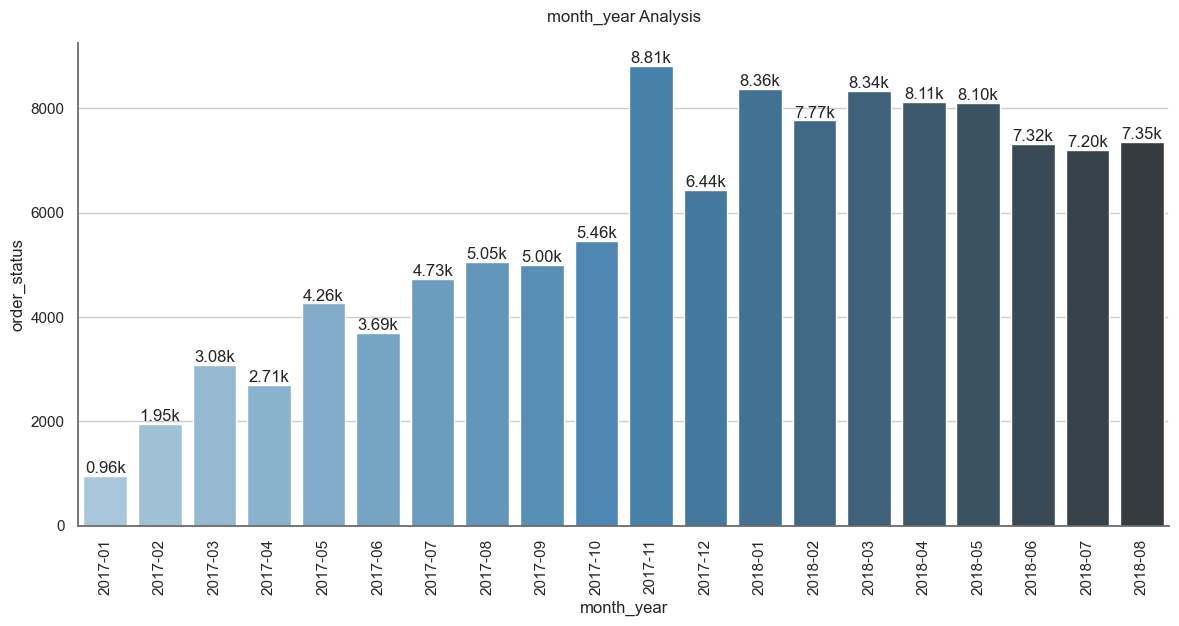

In [191]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_sales = df.groupby('month_year')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='order_status', df=df_monthly_sales, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

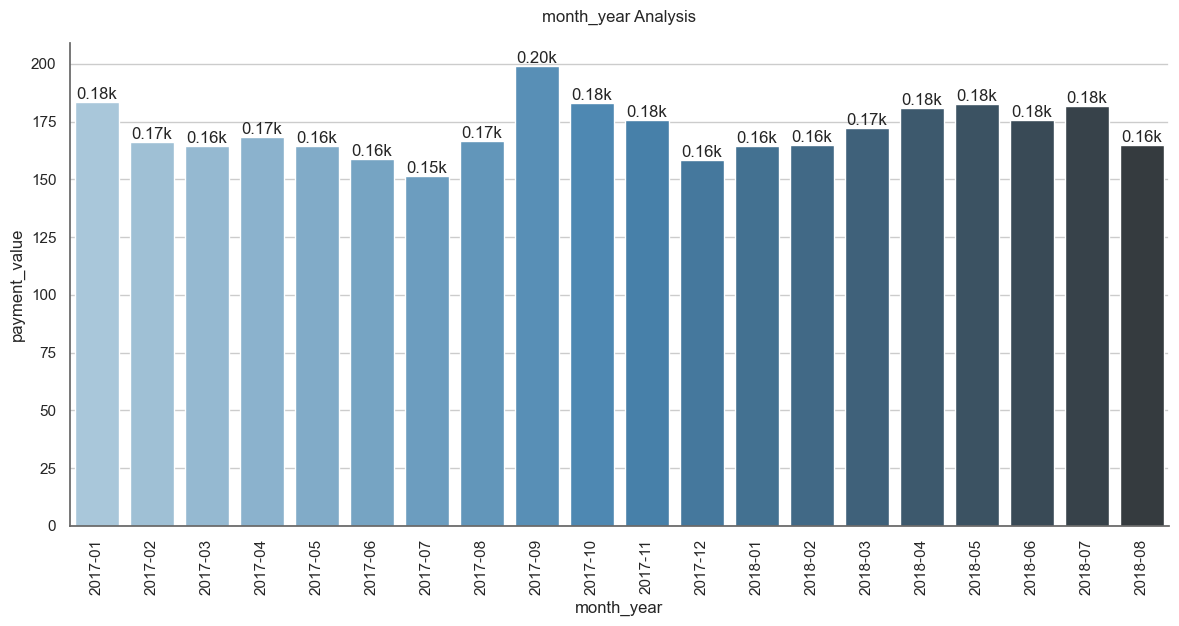

In [192]:
# create a new dataframe for average revenue by taking the mean of it
df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [193]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
df = pd.merge(df, df_min_purchase, on='customer_unique_id')

In [194]:
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
df['usertype'] = 'New'
df.loc[df['month_y']>df['minpurchasedate'],'usertype'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = df.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201701,New,2017-01,176376.56
1,201702,Existing,2017-02,111.07
2,201702,New,2017-02,323704.88
3,201703,Existing,2017-03,596.38
4,201703,New,2017-03,505139.45
5,201704,Existing,2017-04,2677.76
6,201704,New,2017-04,453430.56
7,201705,Existing,2017-05,6733.95
8,201705,New,2017-05,694385.65
9,201706,Existing,2017-06,6956.06


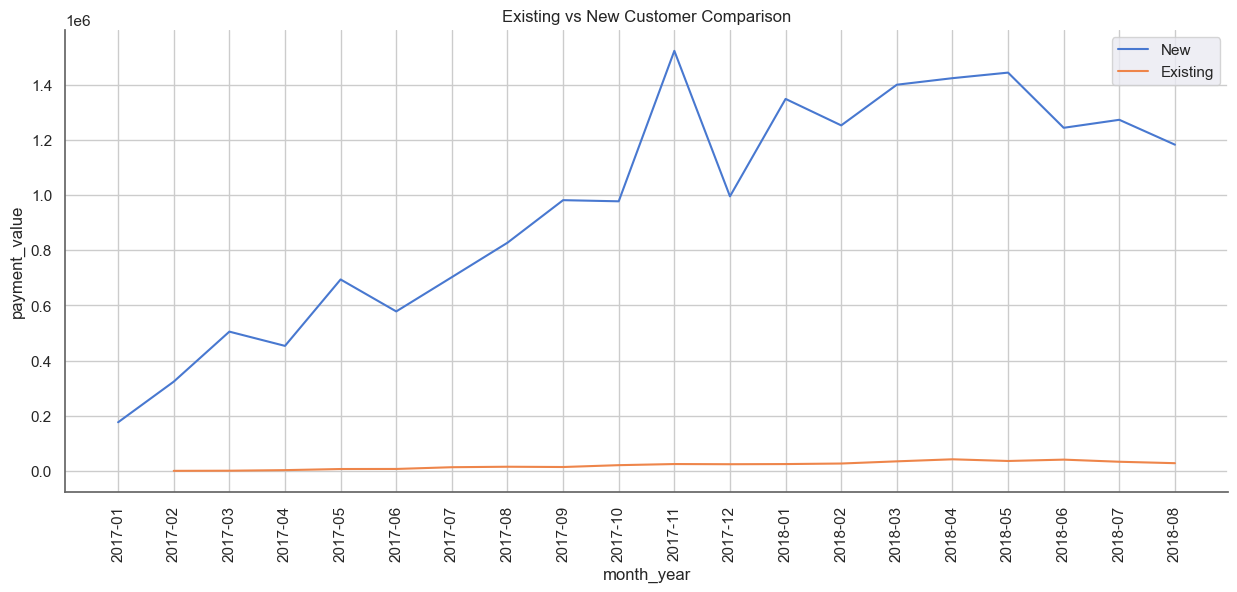

In [195]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [196]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

#dropping nan values that resulted from first and last month
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

#print the dafaframe
df_user_ratio

,month_year,NewCusRatio
1,2017-02,808.000000
2,2017-03,500.600000
3,2017-04,132.764706
4,2017-05,123.214286
5,2017-06,77.871795
6,2017-07,76.591837
7,2017-08,71.175439
8,2017-09,51.333333
9,2017-10,49.193182
10,2017-11,57.868852


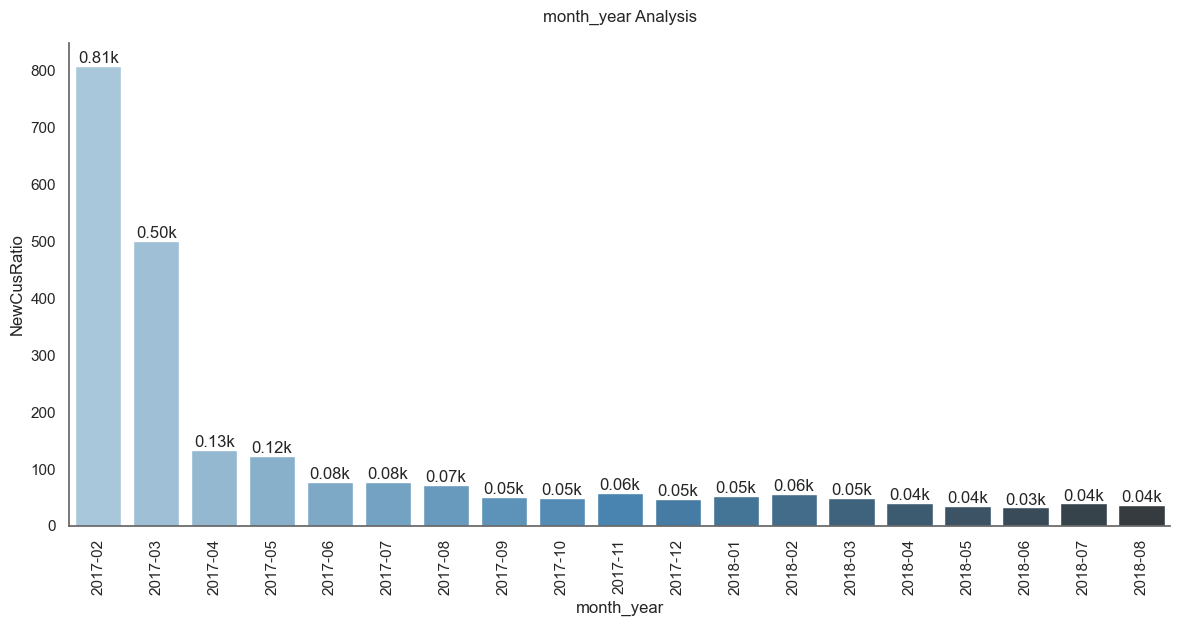

In [197]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [198]:
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total (using crosstab)

#identifying active users are active by looking at their revenue per month
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [199]:
#identifying active users are active by looking at their order count per month
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


In [200]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y,customer_unique_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [201]:
#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201703,2508,3,0.001196
1,201704,2274,11,0.004837
2,201705,3478,14,0.004025
3,201706,3076,16,0.005202
4,201707,3802,16,0.004208
5,201708,4114,23,0.005591
6,201709,4082,32,0.007839
7,201710,4417,32,0.007245
8,201711,7182,37,0.005152
9,201712,5450,41,0.007523


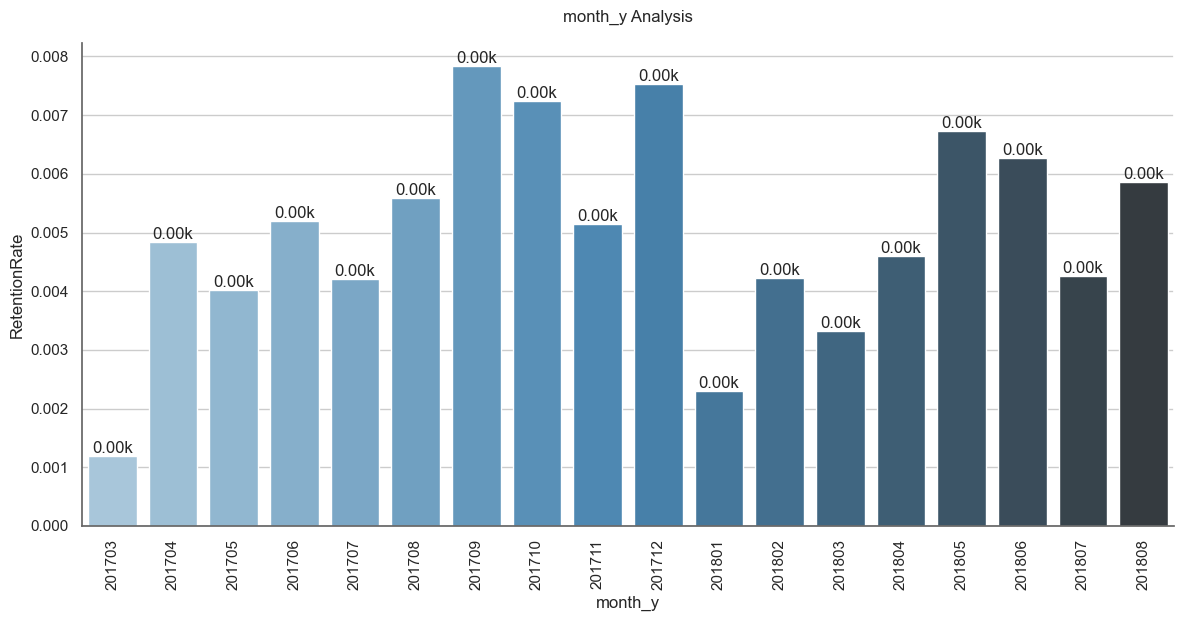

In [202]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_y', y='RetentionRate', df=df_retention, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [203]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
new_column_names = [ 'm_' + str(column) for column in df_retention.columns]
df_retention.columns = new_column_names

In [204]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)

In [205]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

#showing new cohort based retention table
df_retention

,TotalUserCount,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
month_y,,,,,,,,,,,,,,,,,,,,
201702,1618,1.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201703,2508,NaN,1.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201704,2274,NaN,NaN,1.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201705,3478,NaN,NaN,NaN,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201706,3076,NaN,NaN,NaN,NaN,1.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201707,3802,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201708,4114,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201709,4082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201710,4417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00


In [206]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,a8b9d3a27068454b1c98cc67d4e31e6f,64
2,6f70c0b2f7552832ba46eb57b1c5651e,260
3,87695ed086ebd36f20404c82d20fca87,266
4,4291db0da71914754618cd789aebcd56,28


In [207]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count    114681.000000
mean        235.937671
std         150.795167
min           0.000000
25%         113.000000
50%         217.000000
75%         344.000000
max         601.000000
Name: Recency, dtype: float64

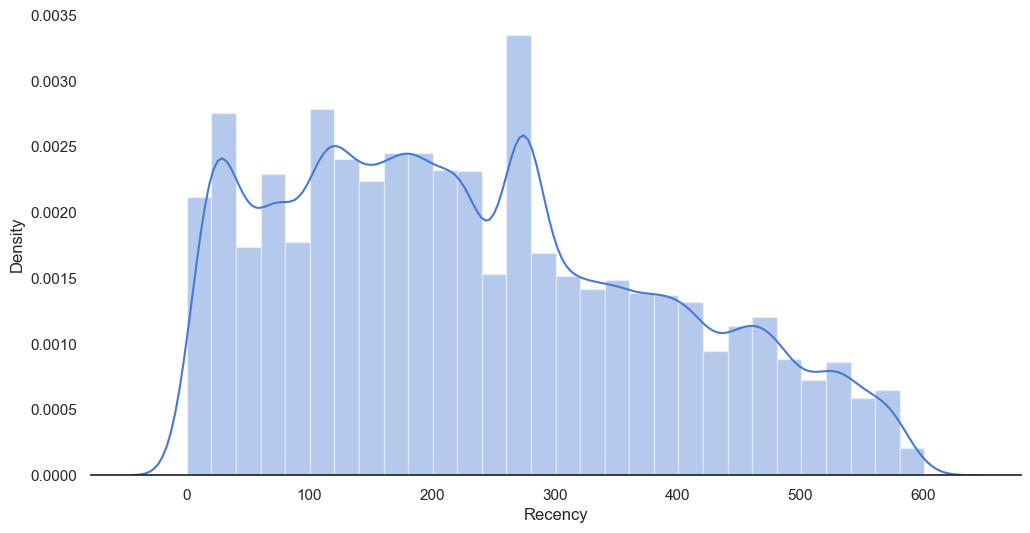

In [208]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

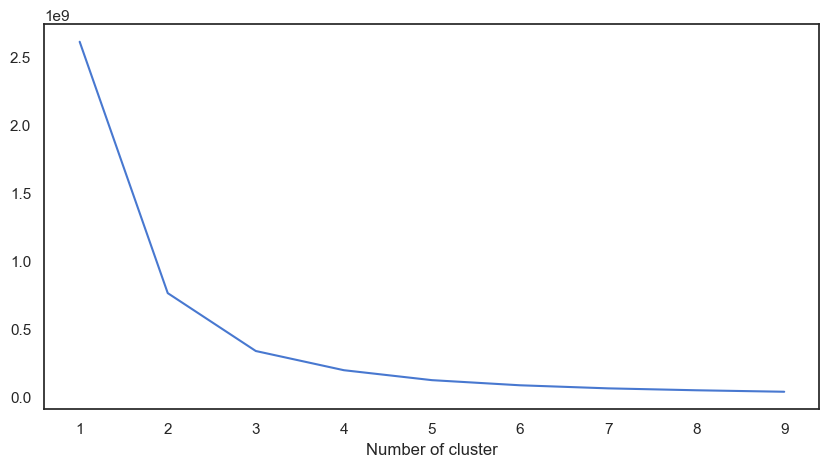

In [209]:
 from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [210]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [211]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,14520.0,503.543595,42.605553,440.0,467.0,496.0,537.0,601.0
1,18398.0,375.236439,33.801377,319.0,346.0,375.0,404.0,439.0
2,27252.0,260.219874,31.029973,207.0,231.0,265.0,281.0,318.0
3,29976.0,152.353082,30.925276,101.0,125.0,153.0,180.0,206.0
4,24535.0,48.260322,27.790662,0.0,24.0,44.0,73.0,100.0


In [212]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

In [213]:
# getting summary statistics of the recency table
df_user.Frequency.describe()

count    114681.000000
mean          1.777496
std           2.774387
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          75.000000
Name: Frequency, dtype: float64

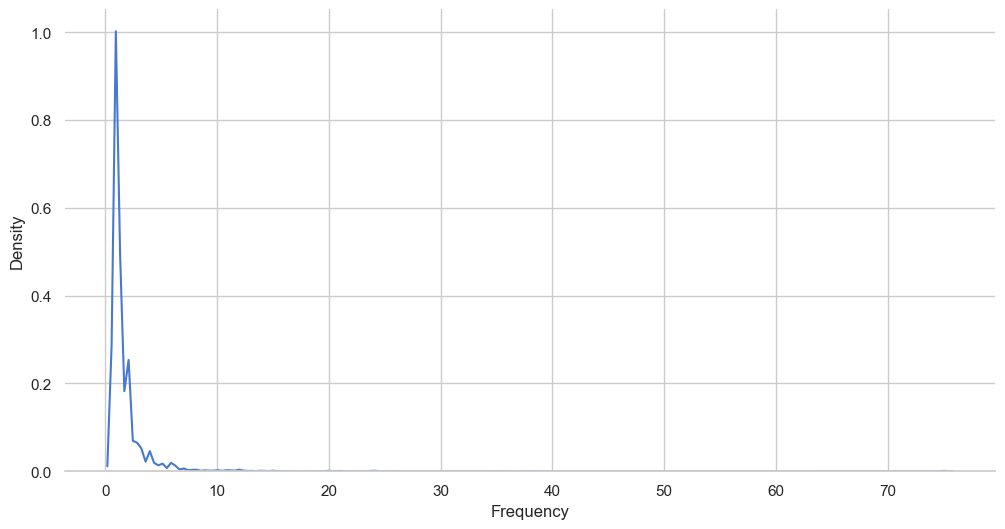

In [214]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [215]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,99875.0,1.207900,0.405807,1.0,1.0,1.0,1.0,2.0
1,12373.0,3.920068,1.047835,3.0,3.0,4.0,5.0,6.0
2,1961.0,9.860785,2.562583,7.0,7.0,9.0,12.0,16.0
3,397.0,24.536524,6.099081,18.0,20.0,22.0,24.0,38.0
4,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


In [216]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

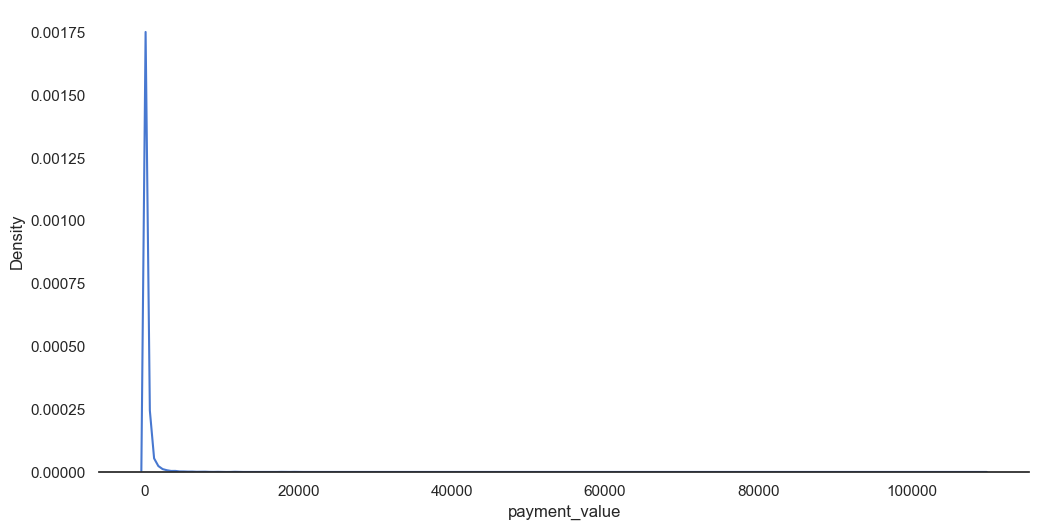

In [217]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

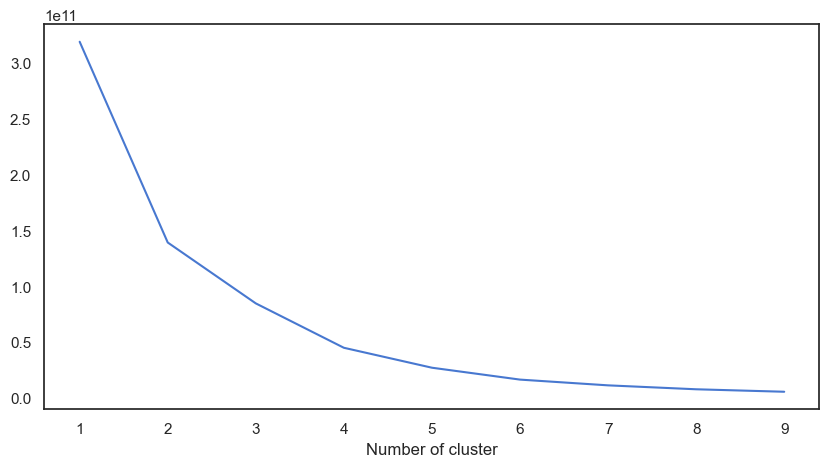

In [218]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [219]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,108440.0,194.693419,195.593107,9.59,67.6100,124.520,234.86,1069.50
1,5290.0,1937.263422,834.776306,1069.77,1301.3925,1647.495,2268.88,4513.32
2,713.0,7106.523829,2117.325473,4534.56,5355.6000,6512.280,8108.64,12490.88
3,184.0,20278.110435,5207.417793,14196.28,16313.6000,19174.380,25051.89,30186.00
4,46.0,43587.292174,2837.177072,36489.24,44048.0000,44048.000,45256.00,45256.00
5,8.0,109312.640000,0.000000,109312.64,109312.6400,109312.640,109312.64,109312.64


In [234]:
print(df_user.shape[1])
column_names = df_user.columns.tolist()
print(column_names)

8
['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster', 'OverallScore']


In [235]:
df_user = df_user.iloc[:, :-1]

In [236]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,502.965506,1.207918,167.045722
1,385.066087,1.366968,199.762601
2,272.598624,1.467501,222.316759
3,169.093415,1.585025,255.279076
4,68.930633,1.674433,304.716812
5,104.920421,6.019153,1145.693739
6,97.927526,6.789547,3087.655157
7,112.614880,11.796499,5572.960722
8,143.403226,11.462366,22318.521129


In [237]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

In [238]:
df_user.head()

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,708ab75d2a007f0564aedd11139c7708,125,3,1,0,99.33,0,3,Low-Value
1,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
2,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
3,0ae522661311f598df20272643d39ce6,160,3,1,0,157.45,0,3,Low-Value
4,d386a136dc889cf681443061874caad8,113,3,1,0,136.71,0,3,Low-Value


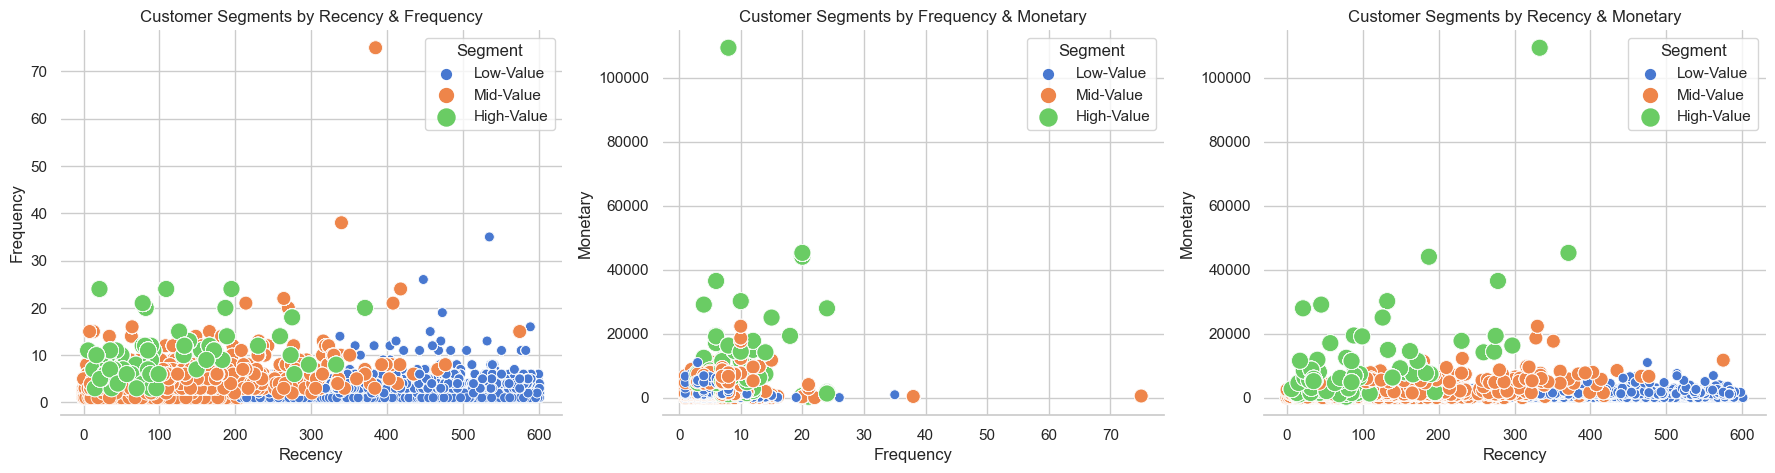

In [239]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

In [240]:
# Calculer les statistiques descriptives pour chaque paire de métriques en fonction des segments de clients
stats_recency_frequency = df_user.groupby('Segment')[['Recency', 'Frequency']].describe()
stats_frequency_monetary = df_user.groupby('Segment')[['Frequency', 'Monetary']].describe()
stats_recency_monetary = df_user.groupby('Segment')[['Recency', 'Monetary']].describe()

# Afficher les statistiques descriptives dans un tableau
print("Statistiques descriptives pour Recency & Frequency :\n", stats_recency_frequency)
print("\nStatistiques descriptives pour Frequency & Monetary :\n", stats_frequency_monetary)
print("\nStatistiques descriptives pour Recency & Monetary :\n", stats_recency_monetary)


Statistiques descriptives pour Recency & Frequency :
             Recency                                                      \
              count        mean         std    min    25%    50%    75%   
Segment                                                                   
High-Value    687.0  119.915575   88.765268    6.0   50.0   89.0  173.0   
Low-Value   84215.0  293.860666  128.746523  101.0  187.0  275.0  391.0   
Mid-Value   29779.0   74.808086   68.928944    0.0   28.0   60.0   90.0   

                  Frequency                                                   
              max     count       mean       std  min  25%   50%   75%   max  
Segment                                                                       
High-Value  371.0     687.0  12.371179  5.981550  3.0  7.0  11.0  15.0  24.0  
Low-Value   601.0   84215.0   1.449112  1.330908  1.0  1.0   1.0   2.0  35.0  
Mid-Value   575.0   29779.0   2.461768  4.521867  1.0  1.0   1.0   3.0  75.0  

Statistiques descrip

In [255]:
import pandas as pd

# Renommer les colonnes
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster','OverallScore'	,'Segment']

# Sélectionner les colonnes pertinentes pour la matrice RFM
df_rfm = df_user[['customer_unique_id', 'Recency', 'Frequency', 'Monetary']].copy()

# Renommer les colonnes
df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Afficher les valeurs RFM
print(df_rfm)


                              CustomerID  Recency  Frequency   Monetary
0       708ab75d2a007f0564aedd11139c7708      125          1      99.33
1       6e3c218d5f0434ddc4af3d6a60767bbf      114          2     192.24
2       6e3c218d5f0434ddc4af3d6a60767bbf      114          2     192.24
3       0ae522661311f598df20272643d39ce6      160          1     157.45
4       d386a136dc889cf681443061874caad8      113          1     136.71
...                                  ...      ...        ...        ...
114676  0a0a92112bd4c708ca5fde585afaa872      333          8  109312.64
114677  0a0a92112bd4c708ca5fde585afaa872      333          8  109312.64
114678  0a0a92112bd4c708ca5fde585afaa872      333          8  109312.64
114679  0a0a92112bd4c708ca5fde585afaa872      333          8  109312.64
114680  0a0a92112bd4c708ca5fde585afaa872      333          8  109312.64

[114681 rows x 4 columns]


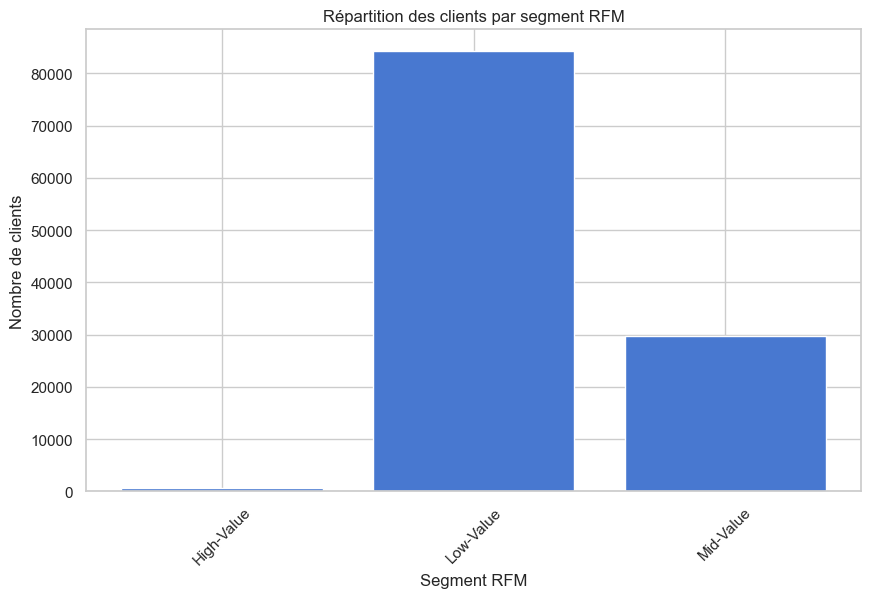

In [260]:
# Supposons que vous avez déjà calculé les segments RFM et stocké les données dans le DataFrame df_user

# Compter le nombre de clients dans chaque segment RFM
df_segment = df_user.groupby('Segment').size().reset_index(name='Count')

# Visualisation de la répartition des clients dans chaque segment RFM
plt.figure(figsize=(10, 6))
plt.bar(df_segment['Segment'], df_segment['Count'])
plt.xlabel('Segment RFM')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par segment RFM')
plt.xticks(rotation=45)
plt.show()


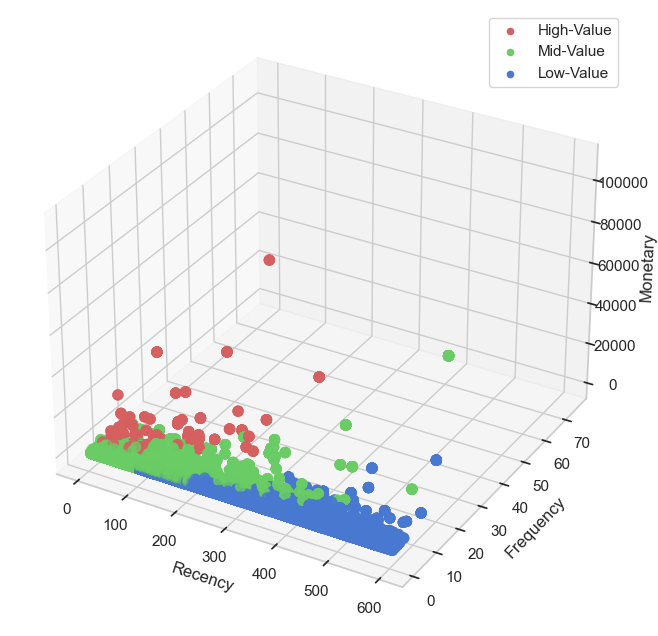

In [256]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Créer une figure et un axe 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Définir les données pour les axes
x = df_rfm['Recency']
y = df_rfm['Frequency']
z = df_rfm['Monetary']

# Définir les couleurs pour chaque segment RFM
colors = {'High-Value': 'r', 'Mid-Value': 'g', 'Low-Value': 'b'}
df_rfm['Segment'] = df_user['Segment'].map(colors)

# Tracer les points dans l'espace 3D
ax.scatter(x, y, z, c=df_rfm['Segment'], s=50, alpha=0.5)

# Étiqueter les axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Ajouter une légende pour les segments RFM
for segment, color in colors.items():
    ax.scatter([], [], [], c=color, label=segment)

# Afficher la légende
ax.legend()

# Afficher le graphique
plt.show()
